In [1]:
import snowflake.connector
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
from sklearn_extra.cluster import KMedoids
from sklearn.datasets import make_blobs

In [2]:
# Establish connection with Snowflake
conn = snowflake.connector.connect(connection_name="fundingsociety.ap-southeast-1.privatelink")

In [3]:
# Write SQL Snowflake Query here
my_query="""


with recency as
         (select t1.CARDUP_PAYMENT_CUSTOMER_COMPANY_ID                                 company_id
               , max(date('2024-09-01')) - max(date(CARDUP_PAYMENT_SUCCESS_AT_UTC_TS)) days_since_last_tx
               , max(date('2024-09-01')) - min(date(CARDUP_PAYMENT_SUCCESS_AT_UTC_TS)) days_since_first_tx
          from ADM.TRANSACTION.CARDUP_PAYMENT_DENORM_T t1
                   join (select company_id
                         from dev.sbox_shilton.cardup_user_managed_unmanaged
                         where owner = 'Unmanaged') t2
                        on t2.company_id = t1.CARDUP_PAYMENT_CUSTOMER_COMPANY_ID

          WHERE CARDUP_PAYMENT_STATUS NOT IN ('Payment Failed', 'Cancelled', 'Refunded', 'Refunding')
            AND CARDUP_PAYMENT_USER_TYPE IN ('business', 'guest')
            and CARDUP_PAYMENT_CU_LOCALE_ID = 1
            and date(CARDUP_PAYMENT_SUCCESS_AT_UTC_TS) >= date('2023-09-01')
            and date(CARDUP_PAYMENT_SUCCESS_AT_UTC_TS) <= date('2024-08-31')
          group by 1),
     freq_mon_main as (select CARDUP_PAYMENT_CUSTOMER_COMPANY_ID
                            , date_trunc(month, date(CARDUP_PAYMENT_SUCCESS_AT_UTC_TS)) month_transaction
                            , owner
                            , sum(cardup_payment_usd_amt)                               sum_monthly_payments
                            , count(distinct DWH_CARDUP_PAYMENT_ID)                     count_monthly_payments
                       from ADM.TRANSACTION.CARDUP_PAYMENT_DENORM_T t1
                                join (select distinct company_id, owner
                                      from dev.sbox_shilton.cardup_user_managed_unmanaged) t2
                                     on t2.company_id = t1.CARDUP_PAYMENT_CUSTOMER_COMPANY_ID
                       WHERE CARDUP_PAYMENT_STATUS NOT IN ('Payment Failed', 'Cancelled', 'Refunded', 'Refunding')
                         AND CARDUP_PAYMENT_USER_TYPE IN ('business', 'guest')
                         and CARDUP_PAYMENT_CU_LOCALE_ID = 1
                         and owner = 'Unmanaged'
                         and date(CARDUP_PAYMENT_SUCCESS_AT_UTC_TS) >= date('2023-09-01')
                         and date(CARDUP_PAYMENT_SUCCESS_AT_UTC_TS) <= date('2024-08-31')
                       group by 1, 2, 3),
     freq_mon_1 as (select CARDUP_PAYMENT_CUSTOMER_COMPANY_ID company_id
                         , min(month_transaction)             first_active_month_p12m
                         , max(month_transaction)             last_active_month_p12m
                         , sum(sum_monthly_payments)          total_payments
                         , sum(count_monthly_payments)        total_payment_count
                    from freq_mon_main
                    group by 1),
     freq_mon as (select company_id
                       , first_active_month_p12m
                       , last_active_month_p12m
                       , total_payments
                       , total_payment_count
                       , total_payments / greatest(1,
                                                   datediff(month, first_active_month_p12m, last_active_month_p12m))      as avg_monthly_payments
                       , total_payment_count / greatest(1,
                                                        datediff(month, first_active_month_p12m, last_active_month_p12m)) as avg_monthly_payment_count
                  from freq_mon_1),
     recurring_main as (select distinct CARDUP_PAYMENT_CUSTOMER_COMPANY_ID
                                      , CARDUP_PAYMENT_SCHEDULE_TYPE
                                      , count(distinct CARDUP_PAYMENT_SCHEDULE_ID)
                                              over (partition by CARDUP_PAYMENT_CUSTOMER_COMPANY_ID)                               count_payment_schedule_id_all
                                      , count(distinct DWH_CARDUP_PAYMENT_ID)
                                              over (partition by CARDUP_PAYMENT_CUSTOMER_COMPANY_ID)                               count_payment_id_all
                                      , count(distinct CARDUP_PAYMENT_SCHEDULE_ID)
                                              over (partition by CARDUP_PAYMENT_CUSTOMER_COMPANY_ID, CARDUP_PAYMENT_SCHEDULE_TYPE) count_payment_schedule_id_by_schedule_type
                                      , count(distinct DWH_CARDUP_PAYMENT_ID)
                                              over (partition by CARDUP_PAYMENT_CUSTOMER_COMPANY_ID, CARDUP_PAYMENT_SCHEDULE_TYPE) count_payment_id_by_schedule_type
                                      , count(distinct CARDUP_PAYMENT_SCHEDULE_ID)
                                              over (partition by CARDUP_PAYMENT_CUSTOMER_COMPANY_ID, CARDUP_PAYMENT_SCHEDULE_TYPE) /
                                        count(distinct CARDUP_PAYMENT_SCHEDULE_ID)
                                              over (partition by CARDUP_PAYMENT_CUSTOMER_COMPANY_ID)                               payment_schedule_id_proportion
                                      , count(distinct DWH_CARDUP_PAYMENT_ID)
                                              over (partition by CARDUP_PAYMENT_CUSTOMER_COMPANY_ID, CARDUP_PAYMENT_SCHEDULE_TYPE) /
                                        count(distinct DWH_CARDUP_PAYMENT_ID)
                                              over (partition by CARDUP_PAYMENT_CUSTOMER_COMPANY_ID)                               payment_id_proportion
                        from ADM.TRANSACTION.CARDUP_PAYMENT_DENORM_T t1
                                 join (select distinct company_id, owner
                                       from dev.sbox_shilton.cardup_user_managed_unmanaged) t2
                                      on t2.company_id = t1.CARDUP_PAYMENT_CUSTOMER_COMPANY_ID
                        WHERE CARDUP_PAYMENT_STATUS NOT IN ('Payment Failed', 'Cancelled', 'Refunded', 'Refunding')
                          AND CARDUP_PAYMENT_USER_TYPE IN ('business', 'guest')
                          and CARDUP_PAYMENT_CU_LOCALE_ID = 1
                          and owner = 'Unmanaged'),
     recurring as (select CARDUP_PAYMENT_CUSTOMER_COMPANY_ID company_id
                        , max(case
                                  when CARDUP_PAYMENT_SCHEDULE_TYPE = 'one off'
                                      then count_payment_schedule_id_by_schedule_type
                                  else 0 end) as             count_payment_schedule_id_oneoff
                        , max(case
                                  when CARDUP_PAYMENT_SCHEDULE_TYPE = 'recurring'
                                      then count_payment_schedule_id_by_schedule_type
                                  else 0 end) as             count_payment_schedule_id_recurring
                        , max(case
                                  when CARDUP_PAYMENT_SCHEDULE_TYPE = 'one off' then count_payment_id_by_schedule_type
                                  else 0 end) as             count_payment_id_oneoff
                        , max(case
                                  when CARDUP_PAYMENT_SCHEDULE_TYPE = 'recurring' then count_payment_id_by_schedule_type
                                  else 0 end) as             count_payment_id_recurring
                        , max(case
                                  when CARDUP_PAYMENT_SCHEDULE_TYPE = 'one off' then payment_schedule_id_proportion
                                  else 0 end) as             payment_schedule_id_proportion_oneoff
                        , max(case
                                  when CARDUP_PAYMENT_SCHEDULE_TYPE = 'recurring' then payment_schedule_id_proportion
                                  else 0 end) as             payment_schedule_id_proportion_recurring
                        , max(case
                                  when CARDUP_PAYMENT_SCHEDULE_TYPE = 'one off' then payment_id_proportion
                                  else 0 end) as             payment_id_proportion_oneoff
                        , max(case
                                  when CARDUP_PAYMENT_SCHEDULE_TYPE = 'recurring' then payment_id_proportion
                                  else 0 end) as             payment_id_proportion_recurring
                   from recurring_main
                   group by 1)
select distinct company_id
              , recency.days_since_first_tx
              , recency.days_since_last_tx
              , freq_mon.avg_monthly_payment_count
              , freq_mon.avg_monthly_payments
              , recurring.payment_schedule_id_proportion_recurring
from dev.sbox_shilton.cardup_user_managed_unmanaged main_unmanaged
         join recency using (company_id)
         join freq_mon using (company_id)
         join recurring using (company_id)
         join (select distinct CARDUP_PAYMENT_CUSTOMER_COMPANY_ID
               from ADM.TRANSACTION.CARDUP_PAYMENT_DENORM_T
               where date(CARDUP_PAYMENT_SUCCESS_AT_UTC_TS) >= date('2024-06-01')) t3
              on t3.CARDUP_PAYMENT_CUSTOMER_COMPANY_ID = main_unmanaged.company_id
where owner = 'Unmanaged';
"""

In [4]:
# Get data from query above
results = conn.cursor().execute(my_query).fetch_pandas_all()

In [5]:
# Check data
results.head()

,COMPANY_ID,DAYS_SINCE_FIRST_TX,DAYS_SINCE_LAST_TX,AVG_MONTHLY_PAYMENT_COUNT,AVG_MONTHLY_PAYMENTS,PAYMENT_SCHEDULE_ID_PROPORTION_RECURRING
0,3039,222,96,1.750000,23179.884700000000,0.000000
1,398,363,6,6.636364,2313.457494218182,0.000000
2,3670,160,7,5.200000,12004.548696000000,0.000000
3,2725,363,6,11.636364,27496.121737636364,0.103774
4,1327,363,34,6.100000,4019.024192680000,0.635659


In [6]:
results.shape

(709, 6)

In [7]:
# Set index
results = results.set_index('COMPANY_ID')
results.head()

,DAYS_SINCE_FIRST_TX,DAYS_SINCE_LAST_TX,AVG_MONTHLY_PAYMENT_COUNT,AVG_MONTHLY_PAYMENTS,PAYMENT_SCHEDULE_ID_PROPORTION_RECURRING
COMPANY_ID,,,,,
3039,222,96,1.750000,23179.884700000000,0.000000
398,363,6,6.636364,2313.457494218182,0.000000
3670,160,7,5.200000,12004.548696000000,0.000000
2725,363,6,11.636364,27496.121737636364,0.103774
1327,363,34,6.100000,4019.024192680000,0.635659


In [8]:
# Change types from object to float
results.AVG_MONTHLY_PAYMENT_COUNT = results.AVG_MONTHLY_PAYMENT_COUNT.astype(float)
results.AVG_MONTHLY_PAYMENTS = results.AVG_MONTHLY_PAYMENTS.astype(float)
results.PAYMENT_SCHEDULE_ID_PROPORTION_RECURRING = results.PAYMENT_SCHEDULE_ID_PROPORTION_RECURRING.astype(float)

In [9]:
# Get sumstats
results.describe()

,DAYS_SINCE_FIRST_TX,DAYS_SINCE_LAST_TX,AVG_MONTHLY_PAYMENT_COUNT,AVG_MONTHLY_PAYMENTS,PAYMENT_SCHEDULE_ID_PROPORTION_RECURRING
count,709.000000,709.000000,709.000000,709.000000,709.000000
mean,234.600846,25.775740,3.883386,17009.536333,0.137686
std,121.373635,33.790802,8.206768,41183.141577,0.266246
min,2.000000,1.000000,0.200000,0.758380,0.000000
25%,115.000000,5.000000,1.090909,2775.395025,0.000000
50%,270.000000,13.000000,1.888889,7340.511696,0.000000
75%,349.000000,33.000000,3.333333,18613.219358,0.142857
max,366.000000,304.000000,101.142857,665145.299181,1.000000


In [10]:
# Transform data
results_transformed = results.copy()
results_transformed['DAYS_SINCE_FIRST_TX'] = np.log((390 - results_transformed['DAYS_SINCE_FIRST_TX']))
# results_transformed['DAYS_SINCE_FIRST_TX'] = (390 - results_transformed['DAYS_SINCE_FIRST_TX'])
results_transformed['DAYS_SINCE_LAST_TX'] = np.log1p(results_transformed['DAYS_SINCE_LAST_TX'])
results_transformed['AVG_MONTHLY_PAYMENT_COUNT'] = np.log1p(results_transformed['AVG_MONTHLY_PAYMENT_COUNT'])
results_transformed['AVG_MONTHLY_PAYMENTS'] = np.log1p(results_transformed['AVG_MONTHLY_PAYMENTS'])

# Check data again
results_transformed.head()

,DAYS_SINCE_FIRST_TX,DAYS_SINCE_LAST_TX,AVG_MONTHLY_PAYMENT_COUNT,AVG_MONTHLY_PAYMENTS,PAYMENT_SCHEDULE_ID_PROPORTION_RECURRING
COMPANY_ID,,,,,
3039,5.123964,4.574711,1.011601,10.051083,0.000000
398,3.295837,1.945910,2.032922,7.746931,0.000000
3670,5.438079,2.079442,1.824549,9.393124,0.000000
2725,3.295837,1.945910,2.536579,10.221837,0.103774
1327,3.295837,3.555348,1.960095,8.299043,0.635659


In [11]:
# Sumstats new data
results_transformed.describe()

,DAYS_SINCE_FIRST_TX,DAYS_SINCE_LAST_TX,AVG_MONTHLY_PAYMENT_COUNT,AVG_MONTHLY_PAYMENTS,PAYMENT_SCHEDULE_ID_PROPORTION_RECURRING
count,709.000000,709.000000,709.000000,709.000000,709.000000
mean,4.650860,2.734644,1.210762,8.779180,0.137686
std,0.949815,1.052210,0.691149,1.501214,0.266246
min,3.178054,0.693147,0.182322,0.564393,0.000000
25%,3.713572,1.791759,0.737599,7.928909,0.000000
50%,4.787492,2.639057,1.060872,8.901300,0.000000
75%,5.616771,3.526361,1.466337,9.831681,0.142857
max,5.961005,5.720312,4.626372,13.407762,1.000000


In [12]:
# Robust Scaler
scaler = RobustScaler()
results_transformed_scaled = pd.DataFrame(scaler.fit_transform(results_transformed), columns=results_transformed.columns, index=results_transformed.index)
results_transformed_scaled.head()

,DAYS_SINCE_FIRST_TX,DAYS_SINCE_LAST_TX,AVG_MONTHLY_PAYMENT_COUNT,AVG_MONTHLY_PAYMENTS,PAYMENT_SCHEDULE_ID_PROPORTION_RECURRING
COMPANY_ID,,,,,
3039,0.176793,1.115907,-0.067612,0.604267,0.000000
398,-0.783762,-0.399600,1.333881,-0.606678,0.000000
3670,0.341839,-0.322619,1.047945,0.258478,0.000000
2725,-0.783762,-0.399600,2.025017,0.694007,0.726419
1327,-0.783762,0.528243,1.233945,-0.316515,4.449617


In [13]:
# Scaled dataset describe
results_transformed_scaled.describe()

,DAYS_SINCE_FIRST_TX,DAYS_SINCE_LAST_TX,AVG_MONTHLY_PAYMENT_COUNT,AVG_MONTHLY_PAYMENTS,PAYMENT_SCHEDULE_ID_PROPORTION_RECURRING
count,709.000000,709.000000,709.000000,709.000000,709.000000
mean,-0.071790,0.055106,0.205684,-0.064180,0.963803
std,0.499063,0.606600,0.948418,0.788961,1.863725
min,-0.845649,-1.121820,-1.205578,-4.381453,0.000000
25%,-0.564271,-0.488468,-0.443607,-0.511039,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.435729,0.511532,0.556393,0.488961,1.000000
max,0.616601,1.776348,4.892705,2.368366,7.000007


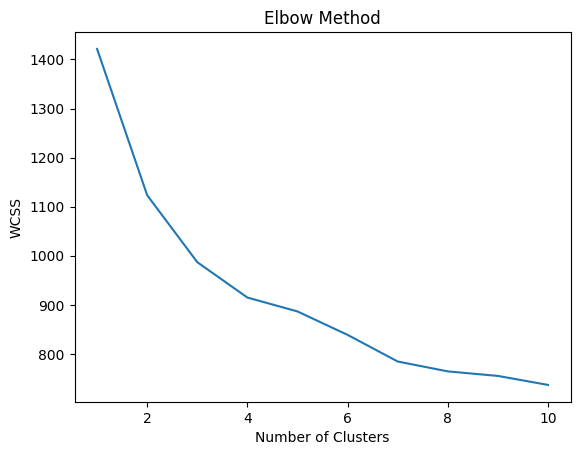

In [14]:
# Determine the optimal number of clusters using the Elbow method
wcss = []
for i in range(1, 11):
    km = KMedoids(n_clusters=i, random_state=42)
    km.fit(results_transformed_scaled)
    wcss.append(km.inertia_)

# Plot the Elbow method graph
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()


In [20]:
km = KMedoids(4, method='pam')
c = km.fit(results_transformed_scaled)
print("Loss is:", c.inertia_)

Loss is: 939.5278282486029


In [21]:
results_transformed_scaled['cluster'] = km.labels_
results_transformed_scaled.head()

,DAYS_SINCE_FIRST_TX,DAYS_SINCE_LAST_TX,AVG_MONTHLY_PAYMENT_COUNT,AVG_MONTHLY_PAYMENTS,PAYMENT_SCHEDULE_ID_PROPORTION_RECURRING,cluster
COMPANY_ID,,,,,,
3039,0.176793,1.115907,-0.067612,0.604267,0.000000,2
398,-0.783762,-0.399600,1.333881,-0.606678,0.000000,0
3670,0.341839,-0.322619,1.047945,0.258478,0.000000,0
2725,-0.783762,-0.399600,2.025017,0.694007,0.726419,0
1327,-0.783762,0.528243,1.233945,-0.316515,4.449617,3
